## 1. ResNet 50 model
A family of deep neural networks that have achieved state-of-the-art performance on a wide range of computer vision tasks.

굉장히 정교함

## 2. VGG16 model 
ImageNet 데이터셋을 기반으로 만든 초기 이미지 분류 모델.
1,000개의 클래스로 나눈 모델이라 정교함.
하지만 무거움

Color features: The VGG16 model may learn to recognize different colors of cats, such as white, black, gray, or orange.

Texture features: The VGG16 model may learn to recognize different textures of cats, such as short or long hair, or smooth or rough fur.

Body features: The VGG16 model may learn to recognize different parts of a cat's body, such as the head, ears, eyes, or tail.

Posture features: The VGG16 model may learn to recognize different postures of cats, such as sitting, standing, or lying down.

Breed features: The VGG16 model may learn to recognize different breeds of cats, such as Siamese, Persian, or Bengal.

## 3. MobileNet  model
A family of lightweight neural networks that are optimized for mobile devices and have a small memory footprint.

연산량과 정확도

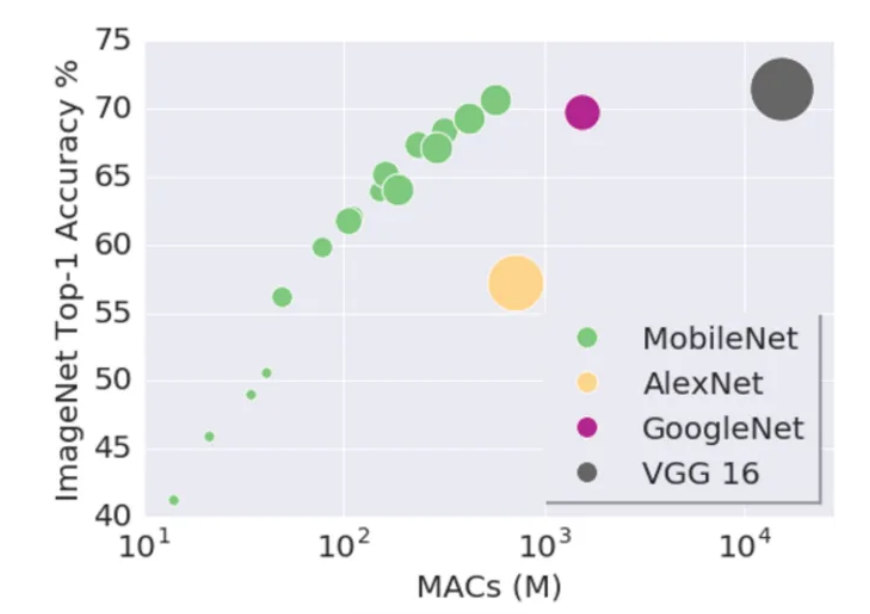

# 최적의 K 값을 어떻게 찾을것인가?

Elbow method: Plot the Within Cluster Sum of Squares (WCSS) for different values of K, and select the value of K where the curve begins to flatten out. This is known as the "elbow" of the curve. This is not always a clear-cut decision, but it can give you an idea of a reasonable range of K values.

Silhouette method: Calculate the Silhouette Coefficient for different values of K. The Silhouette Coefficient measures how similar an object is to its own cluster compared to other clusters. The optimal number of clusters K is the one that maximizes the Silhouette Coefficient. This method is more computationally expensive than the elbow method, but it can give you a more precise answer.

Gap statistic method: Calculate the Gap Statistic for different values of K. The Gap Statistic compares the total within intra-cluster variation for different values of K with their expected values under a null reference distribution of the data. The optimal number of clusters is the value of K that maximizes the gap statistic. This method is more computationally expensive than the elbow method, but it can give you a more precise answer.

In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import torch
import torchvision.models as models
import torchvision.transforms as transforms

from glob import glob
from sklearn.model_selection import train_test_split
import yaml
from IPython.display import Image
import dlib, cv2
import pandas as pd
import random
import keras, datetime
from keras.layers import Input, Dense 
from keras.models import Model
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from keras.applications.mobilenet_v2 import MobileNetV2


In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 15535, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 15535 (delta 54), reused 92 (delta 45), pack-reused 15393
Receiving objects: 100% (15535/15535), 14.58 MiB | 15.96 MiB/s, done.
Resolving deltas: 100% (10578/10578), done.


In [ ]:
%cd yolov5

/content/yolov5


In [ ]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.5 MB/s eta 0:00:00


In [ ]:
cd ..

/content


In [ ]:
img_size = 224
base_path = './drive/MyDrive/Dataset/Version1_Dataset' 
file_list = sorted(os.listdir(base_path))
random.shuffle(file_list)

In [ ]:
print(len(file_list))

34


# Pre-Processing

In [ ]:
def resize_img(im):
  old_size = im.shape[:2] # old_size is in (height, width) format
  ratio = float(img_size) / max(old_size)
  new_size = tuple([int(x*ratio) for x in old_size])
  # new_size should be in (width, height) format
  im = cv2.resize(im, (new_size[1], new_size[0]))
  delta_w = img_size - new_size[1]
  delta_h = img_size - new_size[0]
  top, bottom = delta_h // 2, delta_h - (delta_h // 2)
  left, right = delta_w // 2, delta_w - (delta_w // 2)
  new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
      value=[0, 0, 0])
  return new_im, ratio, top, left

# ResNet50 을 이용한 특징 추출

In [ ]:
def extract_features(directory):
    # Load the ResNet50 model
    model = ResNet50(weights='imagenet', include_top=False)

    features = []
    for img_name in os.listdir(directory):
        # Load the image and preprocess it
        img_path = os.path.join(directory, img_name)
        img = cv2.imread(img_path)
        img, ratio, top, left = resize_img(img)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        # Extract features using the ResNet50 model
        features.append(model.predict(x).ravel())

    return np.array(features)

def cluster_images(directory, num_clusters):
    # Extract features from the images
    features = extract_features(directory)

    # Perform K-means clustering on the features
    kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(features)

    # Reduce the dimensionality of the features to 2 dimensions using PCA
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(features)

    # Plot the clusters using a scatter plot
    plt.scatter(pca_features[:, 0], pca_features[:, 1], c=kmeans.labels_, cmap='rainbow')
    plt.show()

    print(pca_features.shape)

    return kmeans.labels_

1/1 [==============================] - 0s 40ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


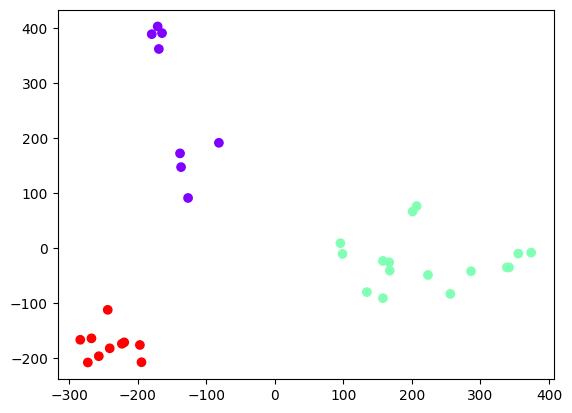

(34, 2)


array([1, 1, 0, 1, 2, 2, 0, 0, 0, 1, 0, 2, 2, 2, 1, 1, 0, 2, 0, 1, 2, 2,
       2, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
directory = 'drive/MyDrive/Dataset/Version1_Dataset'
n_clusters = 3
cluster_images(directory, n_clusters)

In [ ]:
def extract_features(directory):
    # Load the ResNet50 model
    model = ResNet50(weights='imagenet', include_top=False)

    features = []
    filenames = []
    for img_name in os.listdir(directory):
        # Load the image and preprocess it
        img_path = os.path.join(directory, img_name)
        img = cv2.imread(img_path)
        img, ratio, top, left = resize_img(img)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        # Extract features using the ResNet50 model
        features.append(model.predict(x).ravel())
        filenames.append(img_name)

    return np.array(features), filenames

def cluster_images(directory, num_clusters):
    # Extract features from the images
    features, filenames = extract_features(directory)

    # Perform K-means clustering on the features
    kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(features)

    # Reduce the dimensionality of the features to 2 dimensions using PCA
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(features)

    # Plot the clusters using a scatter plot with filename annotations
    plt.scatter(pca_features[:, 0], pca_features[:, 1], c=kmeans.labels_, cmap='rainbow')
    for i, txt in enumerate(filenames):
        plt.annotate(txt, (pca_features[i, 0], pca_features[i, 1]))
    plt.show()

    return kmeans.labels_

In [ ]:
directory = 'drive/MyDrive/Dataset/Version1_Dataset'
n_clusters = 3
cluster_images(directory, n_clusters)

TypeError: ignored

### ResNet50 + PCA 주성분분석 

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score
from collections import Counter

In [ ]:
cd ./

/content


In [ ]:
# cat_dir = './drive/MyDrive/Dataset/Dataset_for_Ear_Detection/result_only_face'
cat_dir = 'drive/MyDrive/Dataset/Version1_Dataset'
# cat_dir = 'drive/MyDrive/Dataset/Dataset_for_Ear_Detection/CAT_00'


In [ ]:
def extract_features(directory):
    # Load the ResNet50 model
    model = ResNet50(weights='imagenet', include_top=False)

    features = []
    labels = []

    for img_name in os.listdir(directory):
        if '.cat' in img_name:
          continue

        print(img_name)
        # Load the image and preprocess it
        img_path = os.path.join(directory, img_name)
        img = cv2.imread(img_path)
        img, ratio, top, left = resize_img(img)
        x = np.expand_dims(img, axis=0)
        x = preprocess_input(x)

        # Extract features using the ResNet50 model
        feature = model.predict(x).ravel()
        features.append(feature)
        if "cat" in img_name:
            labels.append(1)
        else:
            labels.append(0)

    return np.array(features), np.array(labels)

In [ ]:
def classify_image(directory, test_img_path):
    # Extract features from the training images
    X_train, y_train = extract_features(directory)

    # Reduce the dimensionality of the features to 50 dimensions using PCA
    pca = PCA(n_components=50)
    X_train_pca = pca.fit_transform(X_train)

    # Fit a K-nearest neighbors classifier on the training features
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train_pca, y_train)

    # Load the test image and preprocess it
    test_img = cv2.imread(test_img_path)
    test_img = cv2.resize(test_img, (224, 224))
    test_x = np.expand_dims(test_img, axis=0)
    test_x = preprocess_input(test_x)

    # Extract features using the ResNet50 model
    test_feature = model.predict(test_x).ravel()

    # Reduce the dimensionality of the test features using the same PCA model as before
    test_feature_pca = pca.transform(np.array([test_feature]))

    # Predict the label of the test image using the K-nearest neighbors classifier
    pred = knn.predict(test_feature_pca)[0]

    if pred == 1:
        return "This is a cat image."
    else:
        return "This is not a cat image."

In [ ]:
def cluster_images_PCA(directory):
    # Extract features from the images
    features, labels = extract_features(directory)

    # Reduce the dimensionality of the features to 34 dimensions using PCA
    pca = PCA(n_components=34)
    pca_features = pca.fit_transform(features)

    # Fit a K-nearest neighbors classifier on the reduced features for clustering
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(pca_features, labels)

    # Make predictions on the features
    cluster_labels = knn.predict(pca_features)

    # Calculate accuracy of clustering
    acc = accuracy_score(labels, cluster_labels)
    print("Accuracy of clustering: {:.2f}%".format(acc * 100))

    # Plot the clusters using a scatter plot with filename annotations
    plt.scatter(pca_features[:, 0], pca_features[:, 1], c=cluster_labels, cmap='rainbow')
    plt.show()

    return cluster_labels

1.jpeg
1/1 [==============================] - 1s 857ms/step
2.jpeg
1/1 [==============================] - 0s 22ms/step
3.jpeg
1/1 [==============================] - 0s 23ms/step
4.jpeg
1/1 [==============================] - 0s 24ms/step
5.jpeg
1/1 [==============================] - 0s 27ms/step
6.jpeg
1/1 [==============================] - 0s 22ms/step
7.jpeg
1/1 [==============================] - 0s 27ms/step
8.jpeg
1/1 [==============================] - 0s 23ms/step
9.jpeg
1/1 [==============================] - 0s 22ms/step
10.jpeg
1/1 [==============================] - 0s 26ms/step
11.jpeg
1/1 [==============================] - 0s 25ms/step
12.jpeg
1/1 [==============================] - 0s 24ms/step
13.jpeg
1/1 [==============================] - 0s 25ms/step
14.jpeg
1/1 [==============================] - 0s 23ms/step
15.jpeg
1/1 [==============================] - 0s 23ms/step
16.jpeg
1/1 [==============================] - 0s 25ms/step
17.jpeg
1/1 [==============================] - 0

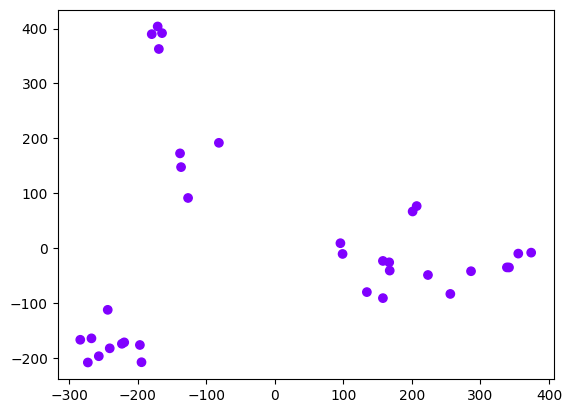

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
cluster_images_PCA(cat_dir)

In [ ]:
def cluster_images_PCA_label(directory):
    # Extract features from the images
    features, labels = extract_features(directory)

    # Reduce the dimensionality of the features to 50 dimensions using PCA
    pca = PCA(n_components=34)
    pca_features = pca.fit_transform(features)

    # Fit a K-nearest neighbors classifier on the reduced features for clustering
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(pca_features, labels)

    # Make predictions on the features
    cluster_labels = knn.predict(pca_features)

    # Calculate accuracy of clustering
    acc = accuracy_score(labels, cluster_labels)
    print("Accuracy of clustering: {:.2f}%".format(acc * 100))

     # Plot the clusters using a scatter plot with filename annotations
    filenames = os.listdir(directory)
    fig, ax = plt.subplots()
    scatter = ax.scatter(pca_features[:, 0], pca_features[:, 1], c=cluster_labels, cmap='rainbow')
    for i, txt in enumerate(filenames):
        ax.annotate(txt, (pca_features[i, 0], pca_features[i, 1]))
    plt.show()

    return cluster_labels

1.jpeg
1/1 [==============================] - 1s 858ms/step
2.jpeg
1/1 [==============================] - 0s 23ms/step
3.jpeg
1/1 [==============================] - 0s 23ms/step
4.jpeg
1/1 [==============================] - 0s 27ms/step
5.jpeg
1/1 [==============================] - 0s 28ms/step
6.jpeg
1/1 [==============================] - 0s 24ms/step
7.jpeg
1/1 [==============================] - 0s 30ms/step
8.jpeg
1/1 [==============================] - 0s 22ms/step
9.jpeg
1/1 [==============================] - 0s 25ms/step
10.jpeg
1/1 [==============================] - 0s 23ms/step
11.jpeg
1/1 [==============================] - 0s 23ms/step
12.jpeg
1/1 [==============================] - 0s 24ms/step
13.jpeg
1/1 [==============================] - 0s 25ms/step
14.jpeg
1/1 [==============================] - 0s 23ms/step
15.jpeg
1/1 [==============================] - 0s 22ms/step
16.jpeg
1/1 [==============================] - 0s 22ms/step
17.jpeg
1/1 [==============================] - 0

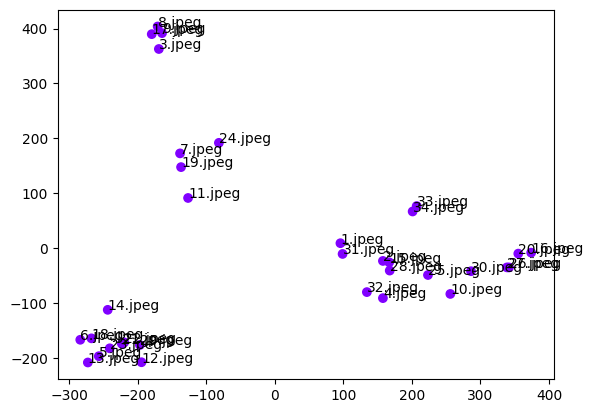

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
cluster_images_PCA_label(cat_dir)

In [ ]:
from PIL import Image

In [ ]:
def cluster_images_PCA_Image(directory):
    # Extract features from the images
    features, labels = extract_features(directory)

    # Reduce the dimensionality of the features to 50 dimensions using PCA
    pca = PCA(n_components=34)
    pca_features = pca.fit_transform(features)

    # Fit a K-nearest neighbors classifier on the reduced features for clustering
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(pca_features, labels)

    # Make predictions on the features
    cluster_labels = knn.predict(pca_features)

    # Calculate accuracy of clustering
    acc = accuracy_score(labels, cluster_labels)
    print("Accuracy of clustering: {:.2f}%".format(acc * 100))

    # Load the images and get their sizes
    img_sizes = []
    img_list = []
    for filename in os.listdir(directory):
        img = cv2.imread(os.path.join(directory, filename))
        img_sizes.append(img.shape[:2][::-1])
        img_list.append(img)

    # Create a figure with subplots
    fig, ax = plt.subplots()

    # Plot the images as scatter points
    scatter = ax.scatter(pca_features[:, 0], pca_features[:, 1], c=cluster_labels, cmap='rainbow')

    # Add annotations with the image thumbnails
    for i, filename in enumerate(os.listdir(directory)):
        img = Image.open(os.path.join(directory, filename))
        img = img.resize((100,100))
        img_sizes[i] = img.size[::-1]
        imagebox = OffsetImage(img, zoom=0.5)
        ab = AnnotationBbox(imagebox, (pca_features[i, 0], pca_features[i, 1]), pad=0, frameon=False)
        ax.add_artist(ab)

    plt.show()

    return cluster_labels

1.jpeg
1/1 [==============================] - 1s 1s/step
2.jpeg
1/1 [==============================] - 0s 23ms/step
3.jpeg
1/1 [==============================] - 0s 23ms/step
4.jpeg
1/1 [==============================] - 0s 24ms/step
5.jpeg
1/1 [==============================] - 0s 22ms/step
6.jpeg
1/1 [==============================] - 0s 22ms/step
7.jpeg
1/1 [==============================] - 0s 22ms/step
8.jpeg
1/1 [==============================] - 0s 23ms/step
9.jpeg
1/1 [==============================] - 0s 24ms/step
10.jpeg
1/1 [==============================] - 0s 22ms/step
11.jpeg
1/1 [==============================] - 0s 22ms/step
12.jpeg
1/1 [==============================] - 0s 24ms/step
13.jpeg
1/1 [==============================] - 0s 22ms/step
14.jpeg
1/1 [==============================] - 0s 24ms/step
15.jpeg
1/1 [==============================] - 0s 23ms/step
16.jpeg
1/1 [==============================] - 0s 23ms/step
17.jpeg
1/1 [==============================] - 0s 2

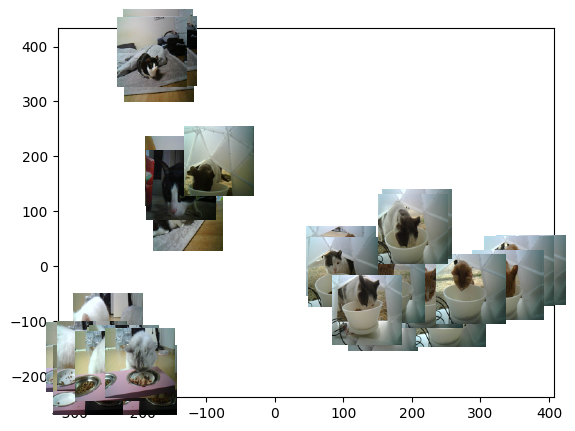

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
cluster_images_PCA_Image(cat_dir)

# VGG16 모델 이용한 특징 추출

In [ ]:
# Load a pre-trained VGG-16 model
model = models.vgg16(pretrained=True)

# Remove the last layer of the model (the classifier)
feature_extractor = torch.nn.Sequential(*list(model.features.children()))

# Set the model to evaluation mode
feature_extractor.eval()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 230MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [ ]:
def extract_features(directory):
    model = VGG16(weights='imagenet', include_top=False)
    features = []
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        img = cv2.imread(img_path)
        img, ratio, top, left = resize_img(img)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        features.append(model.predict(x).ravel())
    return np.array(features)


def cluster_images(directory, num_clusters):
    features = extract_features(directory)
    kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(features)
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(features)
    plt.scatter(pca_features[:, 0], pca_features[:, 1], c=kmeans.labels_, cmap='rainbow')
    plt.show()
    return kmeans.labels_


1/1 [==============================] - 0s 18ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


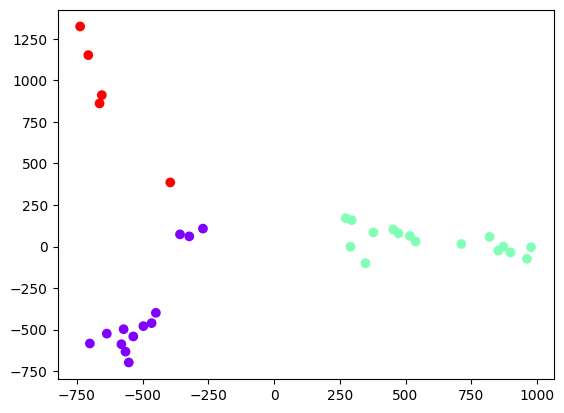

array([1, 1, 2, 1, 0, 0, 0, 2, 2, 1, 0, 0, 0, 0, 1, 1, 2, 0, 2, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
directory = 'drive/MyDrive/Dataset/Version1_Dataset'
n_clusters = 3
cluster_images(directory, n_clusters)


In [ ]:
def extract_features(directory):
    model = VGG16(weights='imagenet', include_top=False)
    features = []
    filenames = []  # store the filename of each image
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        img = cv2.imread(img_path)
        img, ratio, top, left = resize_img(img)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        features.append(model.predict(x).ravel())
        filenames.append(img_name)  # append the filename to the list
    return np.array(features), filenames


def cluster_images(directory, num_clusters):
    features, filenames = extract_features(directory)
    kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(features)
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(features)
    
    # plot the clusters with filenames instead of colored dots
    for i in range(num_clusters):
        plt.scatter(pca_features[kmeans.labels_==i, 0], pca_features[kmeans.labels_==i, 1], label=f'Cluster {i+1}')
        for j, filename in enumerate(filenames):
            if kmeans.labels_[j] == i:
                plt.annotate(filename, xy=(pca_features[j, 0], pca_features[j, 1]))
    plt.legend()
    plt.show()
    
    return kmeans.labels_

1/1 [==============================] - 0s 27ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


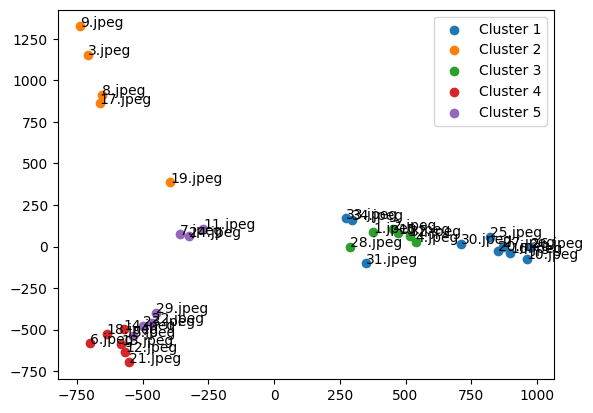

array([2, 2, 1, 2, 4, 3, 4, 1, 1, 0, 4, 3, 3, 3, 2, 0, 1, 3, 1, 0, 3, 4,
       4, 4, 0, 0, 0, 2, 4, 0, 0, 2, 0, 0], dtype=int32)

In [ ]:
directory = 'drive/MyDrive/Dataset/Version1_Dataset'
n_clusters = 5
cluster_images(directory, n_clusters)

### VGG + PCA

In [ ]:
def extract_features(directory):
    # Load the ResNet50 model
    model = VGG16(weights='imagenet', include_top=False)

    features = []
    labels = []
    for img_name in os.listdir(directory):
        # Load the image and preprocess it
        img_path = os.path.join(directory, img_name)
        img = cv2.imread(img_path)
        img, ratio, top, left = resize_img(img)
        x = np.expand_dims(img, axis=0)
        x = preprocess_input(x)

        # Extract features using the ResNet50 model
        feature = model.predict(x).ravel()
        features.append(feature)
        if "cat" in img_name:
            labels.append(1)
        else:
            labels.append(0)

    return np.array(features), np.array(labels)

In [ ]:
def cluster_images(directory):
    # Extract features from the images
    features, labels = extract_features(directory)

    # Reduce the dimensionality of the features to 50 dimensions using PCA
    pca = PCA(n_components=34)
    pca_features = pca.fit_transform(features)

    # Fit a K-nearest neighbors classifier on the reduced features for clustering
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(pca_features, labels)

    # Make predictions on the features
    cluster_labels = knn.predict(pca_features)

    # Calculate accuracy of clustering
    acc = accuracy_score(labels, cluster_labels)
    print("Accuracy of clustering: {:.2f}%".format(acc * 100))

    # Plot the clusters using a scatter plot with filename annotations
    plt.scatter(pca_features[:, 0], pca_features[:, 1], c=cluster_labels, cmap='rainbow')
    plt.show()

    return cluster_labels

1/1 [==============================] - 0s 22ms/step
Accuracy of clustering: 100.00%


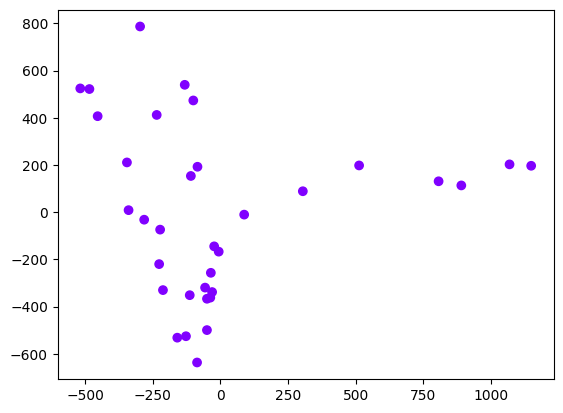

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
cluster_images(cat_dir)

In [ ]:
def cluster_images(directory):
    # Extract features from the images
    features, labels = extract_features(directory)

    # Reduce the dimensionality of the features to 50 dimensions using PCA
    pca = PCA(n_components=34)
    pca_features = pca.fit_transform(features)

    # Fit a K-nearest neighbors classifier on the reduced features for clustering
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(pca_features, labels)

    # Make predictions on the features
    cluster_labels = knn.predict(pca_features)

    # Calculate accuracy of clustering
    acc = accuracy_score(labels, cluster_labels)
    print("Accuracy of clustering: {:.2f}%".format(acc * 100))

     # Plot the clusters using a scatter plot with filename annotations
    filenames = os.listdir(directory)
    fig, ax = plt.subplots()
    scatter = ax.scatter(pca_features[:, 0], pca_features[:, 1], c=cluster_labels, cmap='rainbow')
    for i, txt in enumerate(filenames):
        ax.annotate(txt, (pca_features[i, 0], pca_features[i, 1]))
    plt.show()

    return cluster_labels

1/1 [==============================] - 0s 25ms/step
Accuracy of clustering: 100.00%


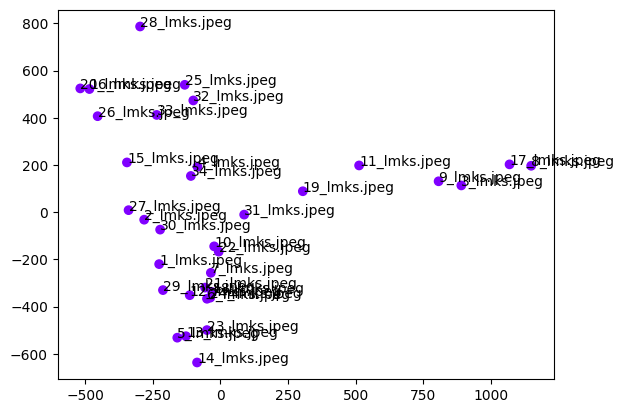

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
cluster_images(cat_dir)

# MobileNet 을 이용한 특징 추출

In [ ]:
def extract_features(directory):
    # Load the MobileNet model
    model = MobileNet(weights='imagenet', include_top=False)

    features = []
    image_paths = []
    for img_name in os.listdir(directory):
        # Load the image and preprocess it
        img_path = os.path.join(directory, img_name)
        img = cv2.imread(img_path)
        img, ratio, top, left = resize_img(img)

        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        # Extract features using the MobileNet model
        features.append(model.predict(x).ravel())
        image_paths.append(img_path)

    return np.array(features), np.array(image_paths)

def cluster_images(directory, num_clusters):
    # Extract features from the images
    features, image_paths = extract_features(directory)

    # Perform K-means clustering on the features
    kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(features)

    # Reduce the dimensionality of the features to 2 dimensions using PCA
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(features)

    # Plot the clusters using a scatter plot with annotated data points
    fig, ax = plt.subplots()
    scatter = ax.scatter(pca_features[:, 0], pca_features[:, 1], c=kmeans.labels_, cmap='rainbow')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')

    # Annotate each data point with its corresponding image name
    for i, img_path in enumerate(image_paths):
        img_name = os.path.basename(img_path)
        ax.annotate(img_name, (pca_features[i, 0], pca_features[i, 1]))

    plt.show()

    return kmeans.labels_

In [ ]:
cd ./

/content


In [ ]:
cluster_images(cat_dir,5)
# cluster_images('./drive/MyDrive/Dataset/Dataset_for_Ear_Detection/result2',4)

In [ ]:
def extract_features(directory):
    # Load the MobileNet model
    model = MobileNet(weights='imagenet', include_top=False)

    features = []
    for img_name in os.listdir(directory):
        # Load the image and preprocess it
        img_path = os.path.join(directory, img_name)
        img = cv2.imread(img_path)
        img, ratio, top, left = resize_img(img)        
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        # Extract features using the MobileNet model
        features.append(model.predict(x).ravel())

    return np.array(features)

def cluster_images(directory, num_clusters):
    # Extract features from the images
    features = extract_features(directory)

    # Perform K-means clustering on the features
    kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(features)

    # Reduce the dimensionality of the features to 2 dimensions using PCA
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(features)

    # Plot the clusters using a scatter plot
    plt.scatter(pca_features[:, 0], pca_features[:, 1], c=kmeans.labels_, cmap='rainbow')
    plt.show()

    return kmeans.labels_

1/1 [==============================] - 0s 34ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


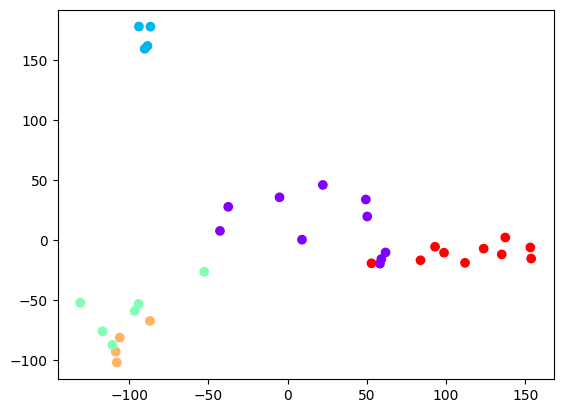

array([0, 0, 1, 0, 3, 2, 0, 1, 1, 4, 0, 2, 2, 2, 0, 4, 1, 2, 0, 4, 2, 3,
       3, 0, 4, 4, 4, 0, 3, 4, 4, 0, 4, 4], dtype=int32)

In [ ]:
cluster_images('drive/MyDrive/Dataset/Version1_Dataset',5)

### MobileNet + PCA

In [ ]:
def extract_features(directory):
    # Load the ResNet50 model
    model = MobileNet(weights='imagenet', include_top=False)

    features = []
    labels = []
    for img_name in os.listdir(directory):
        # Load the image and preprocess it
        img_path = os.path.join(directory, img_name)
        img = cv2.imread(img_path)
        img, ratio, top, left = resize_img(img)
        x = np.expand_dims(img, axis=0)
        x = preprocess_input(x)

        # Extract features using the ResNet50 model
        feature = model.predict(x).ravel()
        features.append(feature)
        if "cat" in img_name:
            labels.append(1)
        else:
            labels.append(0)

    return np.array(features), np.array(labels)

In [ ]:
def cluster_images(directory):
    # Extract features from the images
    features, labels = extract_features(directory)

    # Reduce the dimensionality of the features to 50 dimensions using PCA
    pca = PCA(n_components=34)
    pca_features = pca.fit_transform(features)

    # Fit a K-nearest neighbors classifier on the reduced features for clustering
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(pca_features, labels)

    # Make predictions on the features
    cluster_labels = knn.predict(pca_features)

    # Calculate accuracy of clustering
    acc = accuracy_score(labels, cluster_labels)
    print("Accuracy of clustering: {:.2f}%".format(acc * 100))

    # Plot the clusters using a scatter plot with filename annotations
    plt.scatter(pca_features[:, 0], pca_features[:, 1], c=cluster_labels, cmap='rainbow')
    plt.show()

    return cluster_labels

1/1 [==============================] - 0s 22ms/step
Accuracy of clustering: 100.00%


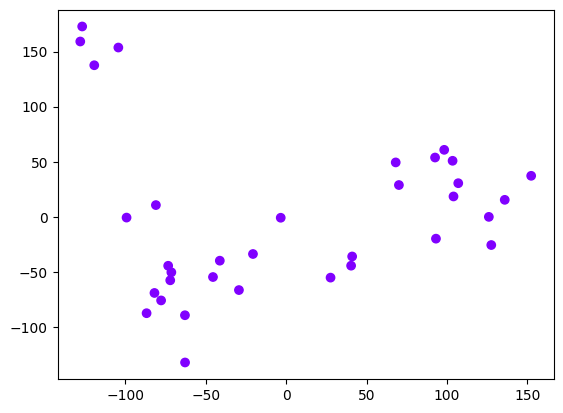

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
cluster_images(cat_dir)

In [ ]:
def cluster_images(directory):
    # Extract features from the images
    features, labels = extract_features(directory)

    # Reduce the dimensionality of the features to 50 dimensions using PCA
    pca = PCA(n_components=34)
    pca_features = pca.fit_transform(features)

    # Fit a K-nearest neighbors classifier on the reduced features for clustering
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(pca_features, labels)

    # Make predictions on the features
    cluster_labels = knn.predict(pca_features)

    # Calculate accuracy of clustering
    acc = accuracy_score(labels, cluster_labels)
    print("Accuracy of clustering: {:.2f}%".format(acc * 100))

     # Plot the clusters using a scatter plot with filename annotations
    filenames = os.listdir(directory)
    fig, ax = plt.subplots()
    scatter = ax.scatter(pca_features[:, 0], pca_features[:, 1], c=cluster_labels, cmap='rainbow')
    for i, txt in enumerate(filenames):
        ax.annotate(txt, (pca_features[i, 0], pca_features[i, 1]))
    plt.show()

    return cluster_labels

1/1 [==============================] - 0s 20ms/step
Accuracy of clustering: 100.00%


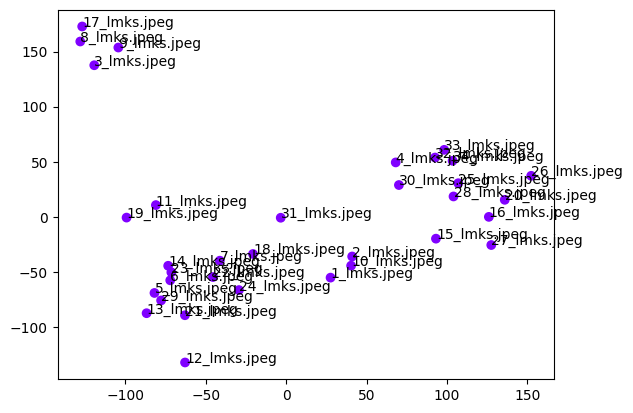

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
cluster_images(cat_dir)